# LangChain: Q&A Over Documents

## Outline
- How to answer questions over a document that exists

# Initital Setup

In [1]:
# API Key setup
import os

api = !cat ../`ls -a ../ | grep "gemini"`

api = api[0]

os.environ['GOOGLE_API_KEY'] = api
# universal variable, used by langchain

# Q&A

In [2]:
# Retrieval chain helps retrieve over documents
from langchain.chains import RetrievalQA

# Our chat model
from langchain_google_genai import ChatGoogleGenerativeAI

# Document loaders to load proprietary data that'll be combined
# With our language model. Here, it's csv
# We have a lot of types of loaders, ranging from simple csv to
# more complex like fb, gdrive, telegram, etc
from langchain.document_loaders import CSVLoader

# VectorStore (TBD in the next course)
from langchain.vectorstores import DocArrayInMemorySearch

# Markdown for jupyter notebooks
from IPython.display import display, Markdown


In [37]:
# Loading CSV data using CSVLoader; Replacement of pandas
loader = CSVLoader("L4_data.csv")

In [19]:
# Helps with creating vector stores easily
from langchain.indexes import VectorstoreIndexCreator

In [20]:
from langchain_google_genai.embeddings import GoogleGenerativeAIEmbeddings

In [21]:
embeddings = GoogleGenerativeAIEmbeddings(
    model="models/embedding-001")

In [34]:
embeddings

GoogleGenerativeAIEmbeddings(model='models/embedding-001', task_type=None, google_api_key=None, client_options=None, transport=None)

In [116]:
# We need to create an index for the vectorStore
# For this, we specify the vectore store class
index = VectorstoreIndexCreator(
    vectorstore_cls=DocArrayInMemorySearch,
    embedding=embeddings
).from_loaders([loader])

---
We created an index for the vector store by passing 2 things:
- vectorestore_cls: vectore store class
- embedding: By default, OpenAI embeddings are used. We had to manually pass in the Google's AI's embeddings

---

In [117]:
query = 'Please list all your shirts with sun protection\
in a table in markdown and summarize each one'

In [118]:
llm = ChatGoogleGenerativeAI(
    model='gemini-pro',
    convert_system_message_to_human = True # Required to avoid error
)

# ValueError: SystemMessages are not yet supported!


In [120]:
resp = index.query(query, llm=llm)

display(Markdown(resp))

I cannot answer this question. The provided context does not list any shirts with sun protection.

---
**For some reason, the model is not responding currectly even though the code is right**

**In the next section, we'll look at a step by step guide, which works fine**

But, let's move as it seems to be an AI compatibility issue with langchain

---



## How exactly does it work? Under The Hood

- We want the LLM's to work on documents
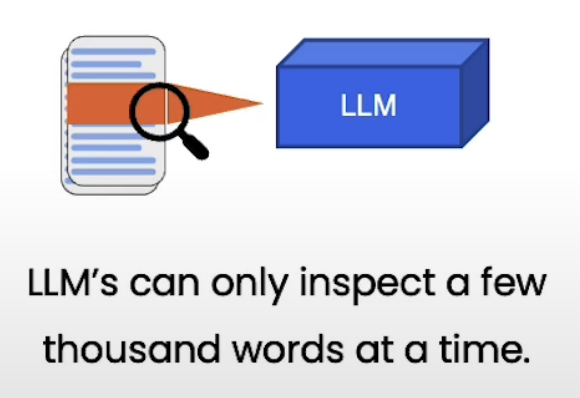

- One key issue is that LLMs can only inspect a few thousand words at a time

- To overcome this issue, embeddings and VectorStores come into play

### Embeddings
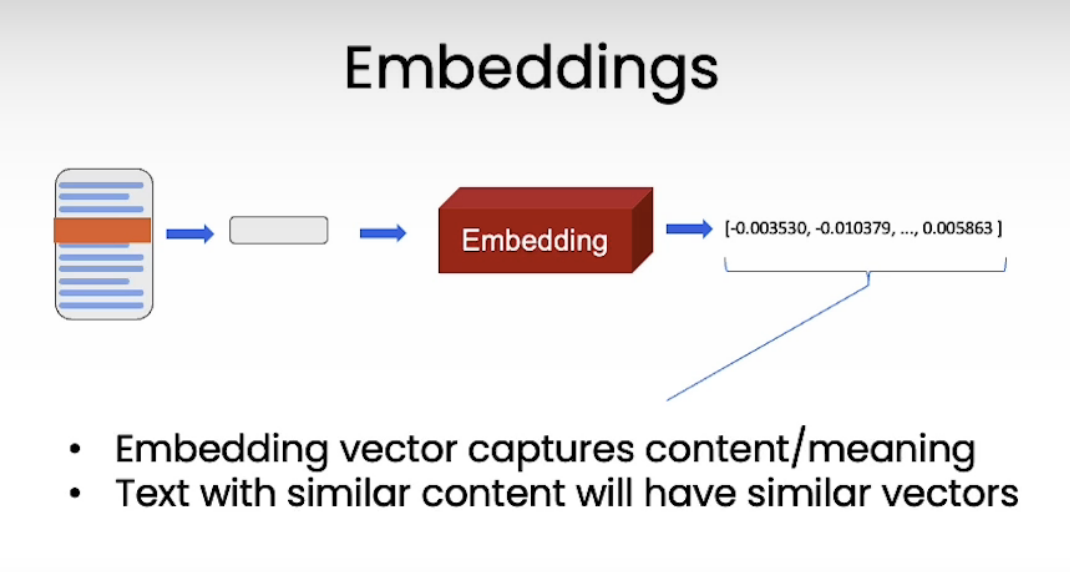

- Embedding is simply converting the string to a numerical vector
    - We studied different ways to it in DL course
    - Word2Vec: CBOW, Skip-Gram
    - SVD methods
    - GloVe method
- Embeddings give us the similarity matrix
    - Like PMI or PPMI
    
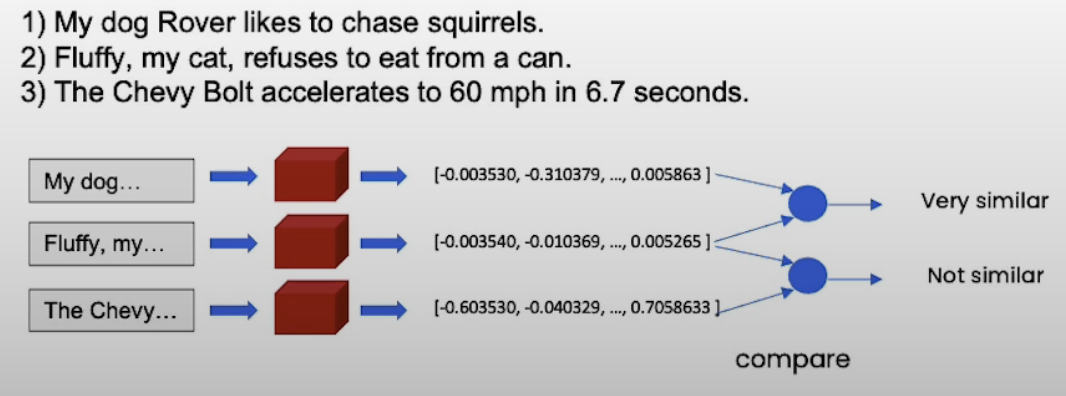

### Vector Database

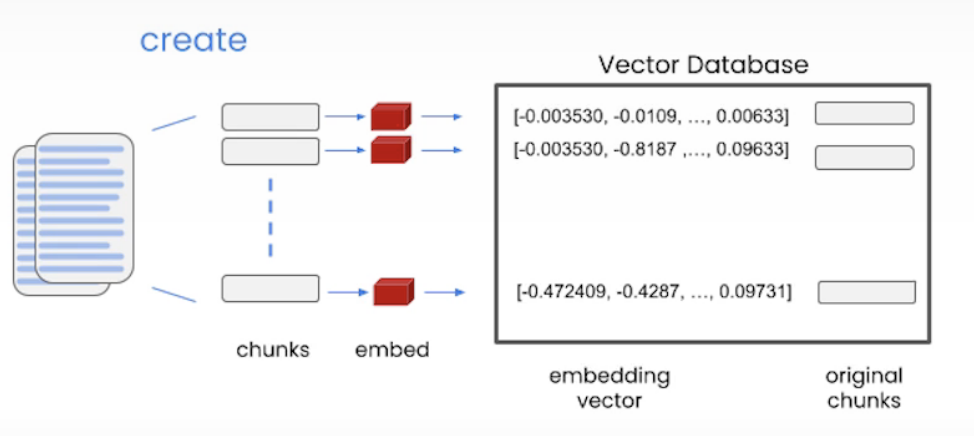

- Vectors created using the embeddings are stored in these vector DBs

- Doc is broken down into chunks, Then the embeddings are created for each of these chunks and then they are stored in the db

- This helps us create an index
- This index can be used to find the most relevant information for the query
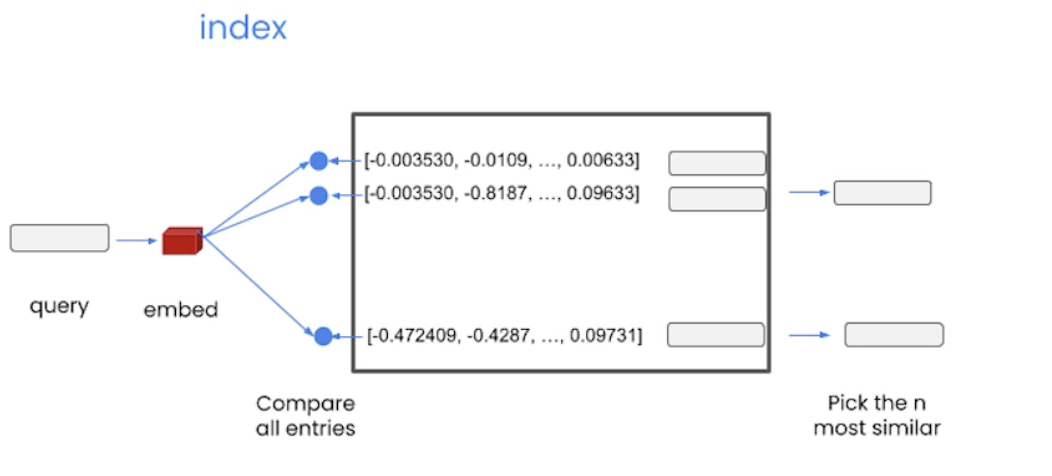

- Query -> embedded -> compared with index -> return relevant info

- The returned values are then fit into the LLM context to get us the response

# Step By Step

In [57]:
# Creating the embedding for a sentence
embed = embeddings.embed_query(query)

print(len(embed))

768


In [82]:
# It's a long vector
# Displaying first 5 elements
embed[:5]

[-0.0013364749, 0.009984099, -0.058846265, -0.018975606, 0.07118893]

In [59]:
# Loading the document loader we created (CSVLoader)
docs = loader.load()

In [60]:
docs[0]

Document(page_content=": 0\nname: Women's Campside Oxfords\ndescription: This ultracomfortable lace-to-toe Oxford boasts a super-soft canvas, thick cushioning, and quality construction for a broken-in feel from the first time you put them on. \n\nSize & Fit: Order regular shoe size. For half sizes not offered, order up to next whole size. \n\nSpecs: Approx. weight: 1 lb.1 oz. per pair. \n\nConstruction: Soft canvas material for a broken-in feel and look. Comfortable EVA innersole with Cleansport NXT® antimicrobial odor control. Vintage hunt, fish and camping motif on innersole. Moderate arch contour of innersole. EVA foam midsole for cushioning and support. Chain-tread-inspired molded rubber outsole with modified chain-tread pattern. Imported. \n\nQuestions? Please contact us for any inquiries.", metadata={'source': 'L4_data.csv', 'row': 0})

In [83]:
# Creating a db from document, using our VectorStore
# Takes a list of document and the embedding obj
# to create an overall vector store
db = DocArrayInMemorySearch.from_documents(
    documents=docs,
    embedding=embeddings
)

In [84]:
query

'Please list all your shirts with sun protectionin a table in markdown and summarize each one'

In [85]:
similar_docs = db.similarity_search(query)

In [87]:
len(similar_docs)

4

In [88]:
similar_docs[0]

Document(page_content=': 255\nname: Sun Shield Shirt by\ndescription: "Block the sun, not the fun – our high-performance sun shirt is guaranteed to protect from harmful UV rays. \n\nSize & Fit: Slightly Fitted: Softly shapes the body. Falls at hip.\n\nFabric & Care: 78% nylon, 22% Lycra Xtra Life fiber. UPF 50+ rated – the highest rated sun protection possible. Handwash, line dry.\n\nAdditional Features: Wicks moisture for quick-drying comfort. Fits comfortably over your favorite swimsuit. Abrasion resistant for season after season of wear. Imported.\n\nSun Protection That Won\'t Wear Off\nOur high-performance fabric provides SPF 50+ sun protection, blocking 98% of the sun\'s harmful rays. This fabric is recommended by The Skin Cancer Foundation as an effective UV protectant.', metadata={'source': 'L4_data.csv', 'row': 255})

In [89]:
# A retriever is a generic interface that takes in a query
# and returns documents
retriever = db.as_retriever()

In [90]:
retriever

VectorStoreRetriever(tags=['DocArrayInMemorySearch'], vectorstore=<langchain_community.vectorstores.docarray.in_memory.DocArrayInMemorySearch object at 0x17d7c6710>)

## First way
- Combine the doc into a single piece of text
- Then pass it to the LLM's prompt query

In [91]:
qdocs = "".join([
    similar_docs[i].page_content 
    for i in range(len(similar_docs))
])


In [92]:
# Passing the query doc to the LLM
resp = llm.invoke(f"{qdocs} question:{query}")

In [93]:
display(Markdown(resp.content))

| Name | Description |
|---|---|
| Sun Shield Shirt | Protects from harmful UV rays, wicks moisture, abrasion resistant, imported |
| Women's Tropical Tee, Sleeveless | UPF 50+ sun protection, wrinkle resistant, flattering fit, imported |
| Men's Tropical Plaid Short-Sleeve Shirt | UPF 50+ sun protection, wrinkle-resistant, front and back cape venting, imported |
| Men's TropicVibe Shirt, Short-Sleeve | UPF 50+ sun protection, lightweight, wrinkle resistant, front and back cape venting, imported |

These shirts are all designed to provide sun protection, with UPF ratings of 50+ to block 98% of the sun's harmful rays. They are made from high-performance fabrics that are moisture-wicking, abrasion-resistant, and wrinkle-resistant. The shirts are also comfortable to wear, with flattering fits and features like cape venting to keep you cool.

## Second way: Better way

- Use a chain to encapsulate everything

In [97]:
qa_stuff = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type='stuff', # to stuff the doc into context
    retriever=retriever, # interface for fetching documents
    verbose=True
)

In [98]:
resp = qa_stuff.invoke(query)



> Entering new RetrievalQA chain...

> Finished chain.


In [109]:
display(Markdown(resp['result']))

| Name | Description |
|---|---|
| Sun Shield Shirt | Blocks 98% of the sun's harmful rays, UPF 50+ rated, moisture-wicking, abrasion-resistant |
| Women's Tropical Tee, Sleeveless | UPF 50+ rated, wrinkle-resistant, low-profile pockets, front and back cape venting, two front pockets, tool tabs, eyewear loop |
| Men's Tropical Plaid Short-Sleeve Shirt | UPF 50+ rated, wrinkle-resistant, front and back cape venting, two front bellows pockets |
| Men's TropicVibe Shirt, Short-Sleeve | UPF 50+ rated, wrinkle-resistant, front and back cape venting, two front bellows pockets |

All of these shirts are made with high-performance fabric that provides SPF 50+ sun protection, blocking 98% of the sun's harmful rays. They are also rated UPF 50+ by The Skin Cancer Foundation, which is the highest rated sun protection possible.

# Stuff Method in Chain Type

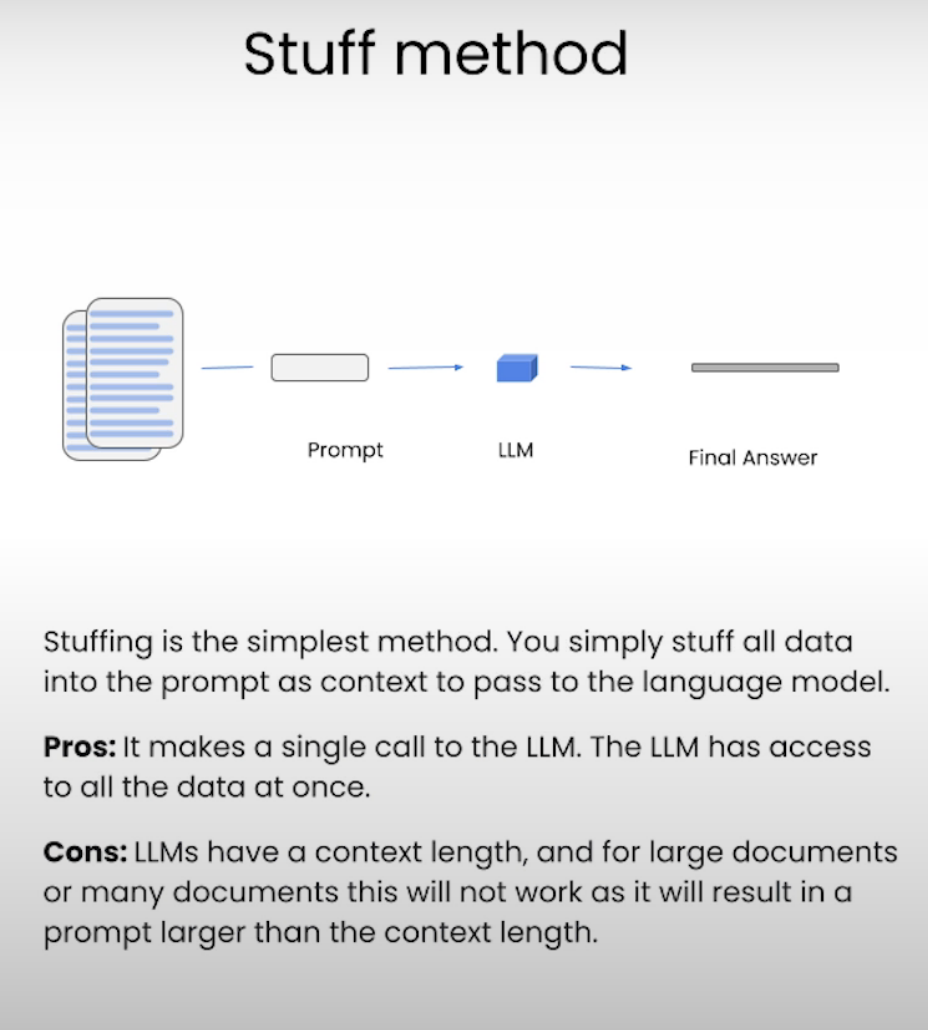

# Additional Methods

## Map_reduce
- Takes all the chunks
- Passes them along with the question to the LLM
- Gets back a response
- Then uses another LLM call to summarize all the individual answers into a final answer
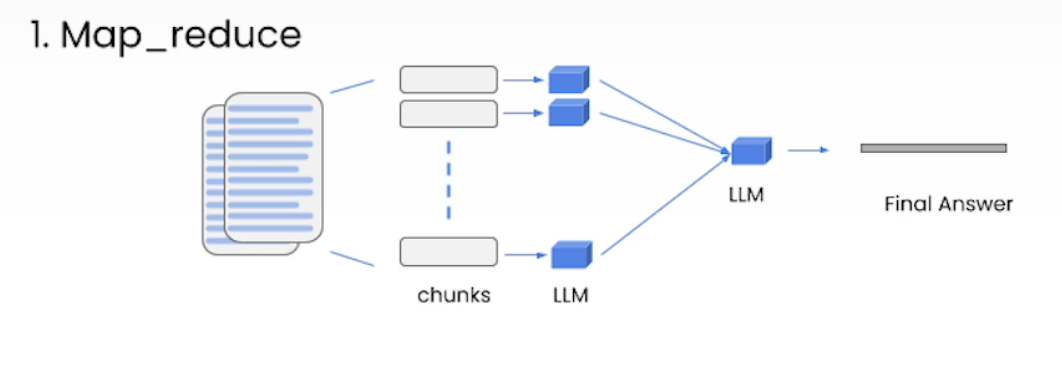

- Powerful as the individual questions can be run in parallel
- **Takes a lot more calls**
- Treats all the docs as independent, which may not always be well suited case
- Often used for summarization of text

## Refine
- Used to loop over many docs in an iterative fashion
- It builds upon the answer from the previous  doc
- Really good for combining info and building up an answer over time
- Leads to longer answers
- Not as fast because of the dependence on the results from the previous calls
- Takes just as many calls as map_reduce
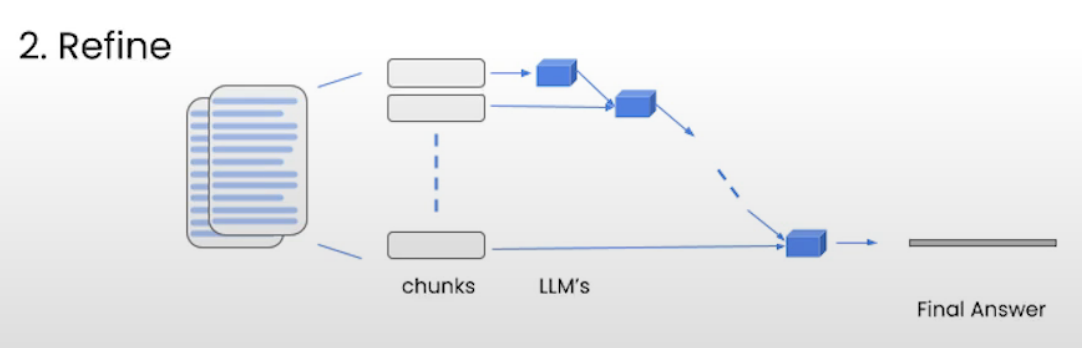

## Map_rerank
- More experimental, as of now
- Single call to the LLM for each doc and also return a score
- Select the highest score
- Relies on the LLM to know what the score should be
    - So, need to specify in the prompt to give a score
    - High score means relevant, low means... blah blah
- All calls are independent

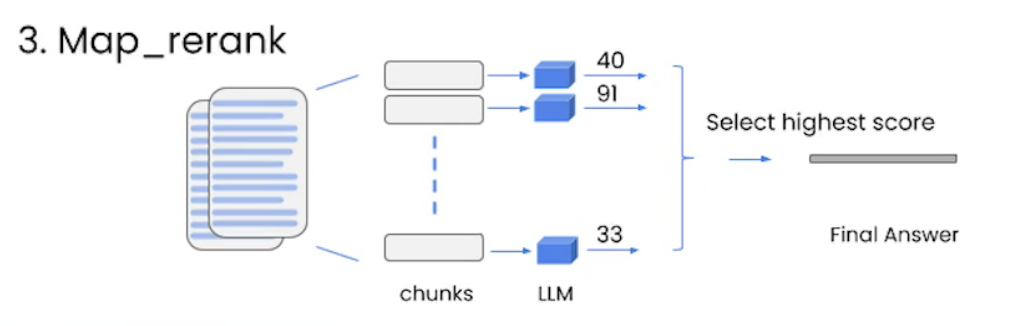

stuff > map_reduce